<a href="https://colab.research.google.com/github/ammarSherif/CIT690E-Deep-Learning-Labs/blob/main/Lab%204%3A%20Batch%20Normalization%20and%20Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Batch Normalization and Dropout

CIT690E: Deep Learning <br>
Nile University<br>
Ammar Sherif<br>
Github Repo: [CIT690E-Deep-Learning-Labs](https://github.com/ammarSherif/CIT690E-Deep-Learning-Labs)

## Outline

During this lab, we cover the principles of batch normalization and show its impact; then, we do the same for dropout

In [1]:
# ==============================================================================
# Some imports that we are using in our lab
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
# ==============================================================================
# Identify the device at the beginning
# ==============================================================================
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Dataset

We will use **FashionMNIST dataset**. It contains 70,000 samples of fashion images. Our objective is to build a model that is able to identify the item in an image. Below are some details:


*   60K training samples
*   10K testing samples
*   10 output classes, **classification**
*   Input image size: 28x28

In [3]:
# ==============================================================================
# Load the data and transform it
# ==============================================================================
train_data = FashionMNIST(root='./data',train=True,download=True,
                          transform=ToTensor())
val_data = FashionMNIST(root='./data',train=False,download=True,
                        transform=ToTensor())

In [4]:
# ==============================================================================
# Build a wraper to the dataset to normalize and flatten
# ==============================================================================
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/(255*10000)
        x = nn.Flatten()(x)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

# ==============================================================================
# Define a method that returns the data_loaders
# ==============================================================================
def get_data():     
    train = FMNISTDataset(train_data.data, train_data.targets)     
    train_loader = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_data.data, val_data.targets)     
    val_loader = DataLoader(val, batch_size=len(val_data.data), shuffle=True)
    return train_loader, val_loader

## Normal FFNN
In this section, we write the code we will be using through our experiments:

In [5]:
# ==============================================================================
# Build a normal Feedforward Neural Network
# ==============================================================================
class FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.__input_to_hidden_layer = nn.Linear(784,1000)
        self.__hidden_layer_activation = nn.ReLU()
        self.__hidden_to_output_layer = nn.Linear(1000,10)
    def forward(self, x):
        # ------------------------------------------------------------------
        # Because we want  to know  the intermediate values,  we return both
        # value of the hidden layer after activation, and the final output. 
        # ------------------------------------------------------------------
        x = self.__input_to_hidden_layer(x)
        x1 = self.__hidden_layer_activation(x)
        y = self.__hidden_to_output_layer(x1)
        return y, x1

In [6]:
# ==============================================================================
# Define a method to perform one single batch training
# ==============================================================================
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()
# ==============================================================================
# Define the accuracy procedure
# ==============================================================================
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [7]:
# ==============================================================================
# Define the loss function and other parameters
# ==============================================================================
loss_fn = nn.CrossEntropyLoss()
model_ffnn = FFNN().to(device)
optimizer_ffnn = Adam(model_ffnn.parameters(), lr=1e-3)

In [8]:
# ==============================================================================
# define the validation loss value
# ==============================================================================
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)[0]
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

### Training and Results

In [9]:
# ==============================================================================
# Define our training procedure
# ==============================================================================
def train_procedure(model,optimizer,trn_dl,val_dl, max_epochs):
  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []
  for epoch in range(max_epochs):
      train_epoch_losses, train_epoch_accuracies = [], []
      for ix, batch in enumerate(iter(trn_dl)):
          x, y = batch
          batch_loss = train_batch(x, y, model, optimizer, loss_fn)
          train_epoch_losses.append(batch_loss)        
      train_epoch_loss = np.array(train_epoch_losses).mean()

      for ix, batch in enumerate(iter(trn_dl)):
          x, y = batch
          is_correct = accuracy(x, y, model)
          train_epoch_accuracies.extend(is_correct)
      train_epoch_accuracy = np.mean(train_epoch_accuracies)

      for ix, batch in enumerate(iter(val_dl)):
          x, y = batch
          val_is_correct = accuracy(x, y, model)
          validation_loss = val_loss(x, y, model)
      val_epoch_accuracy = np.mean(val_is_correct)

      print(f"Epoch [{epoch+1:2}]: Train Acc: {train_epoch_accuracy:.2%}, \
          \tVal Acc: {val_epoch_accuracy:.2%}")
      train_losses.append(train_epoch_loss)
      train_accuracies.append(train_epoch_accuracy)
      val_losses.append(validation_loss)
      val_accuracies.append(val_epoch_accuracy)

  return train_losses, train_accuracies, val_losses, val_accuracies

In [10]:
# ==============================================================================
# Get the training data loader
# ==============================================================================
max_epochs = 40
train_loader, val_loader = get_data()
# ==============================================================================
# Train
# ==============================================================================
train_losses, train_accuracies, val_losses, val_accuracies = \
    train_procedure(model_ffnn, optimizer_ffnn, train_loader, val_loader, 
                    max_epochs)

Epoch [ 1]: Train Acc: 53.68%,           	Val Acc: 53.31%
Epoch [ 2]: Train Acc: 66.07%,           	Val Acc: 65.72%
Epoch [ 3]: Train Acc: 70.28%,           	Val Acc: 70.39%
Epoch [ 4]: Train Acc: 72.46%,           	Val Acc: 72.44%
Epoch [ 5]: Train Acc: 74.01%,           	Val Acc: 73.70%
Epoch [ 6]: Train Acc: 75.38%,           	Val Acc: 74.98%
Epoch [ 7]: Train Acc: 75.55%,           	Val Acc: 75.36%
Epoch [ 8]: Train Acc: 76.87%,           	Val Acc: 76.48%
Epoch [ 9]: Train Acc: 77.05%,           	Val Acc: 76.32%
Epoch [10]: Train Acc: 78.42%,           	Val Acc: 77.92%
Epoch [11]: Train Acc: 78.72%,           	Val Acc: 77.95%
Epoch [12]: Train Acc: 79.17%,           	Val Acc: 78.19%
Epoch [13]: Train Acc: 79.45%,           	Val Acc: 78.67%
Epoch [14]: Train Acc: 79.10%,           	Val Acc: 78.06%
Epoch [15]: Train Acc: 80.48%,           	Val Acc: 79.44%
Epoch [16]: Train Acc: 80.70%,           	Val Acc: 79.56%
Epoch [17]: Train Acc: 81.30%,           	Val Acc: 80.19%
Epoch [18]: Tr

In [11]:
# ==============================================================================
# Plot the model loss and accuracy
# ==============================================================================
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = np.arange(max_epochs)+1
    plt.subplot(211)
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    #plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Training and validation loss with very small input values')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()
    plt.subplot(212)
    plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    #plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Training and validation accuracy with very small input values')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.ylim(0.8,1)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca()\
                              .get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()

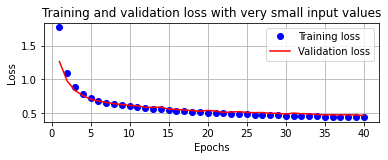

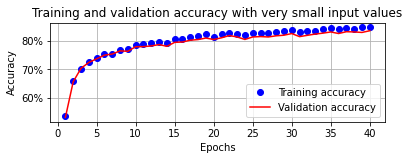

In [12]:
plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies)

In [13]:
# ==============================================================================
# Show hidden layer node values
# ==============================================================================
def show_hidden_dist(model, data_loader, title="Hidden Value Distribution"):
    x, _ = next(iter(data_loader))
    # --------------------------------------------------------------------------
    # Get the distribution of the values in the hidden layer
    # --------------------------------------------------------------------------
    plt.hist(model(x)[1].cpu().detach().numpy().flatten())
    plt.title("Hidden Value Distribution")

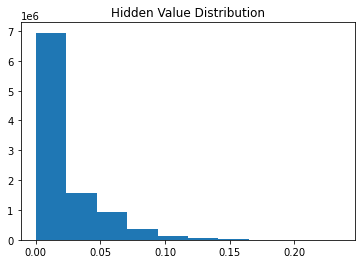

In [14]:
show_hidden_dist(model_ffnn, val_loader)

In [15]:
def plot_weight_dist(model):
  for ix, par in enumerate(model.parameters()):
      if(ix==0):
          plt.hist(par.cpu().detach().numpy().flatten())
          #plt.xlim(-2,2)
          plt.title('Distribution of weights [input to hidden]')
          plt.show()
      elif(ix ==1):
          plt.hist(par.cpu().detach().numpy().flatten())
          #plt.xlim(-2,2)
          plt.title('Distribution of biases of hidden layer')
          plt.show()
      elif(ix==2):
          plt.hist(par.cpu().detach().numpy().flatten())
          #plt.xlim(-2,2)
          plt.title('Distribution of weights [hidden to output]')
          plt.show()
      elif(ix ==3):
          plt.hist(par.cpu().detach().numpy().flatten())
          #plt.xlim(-2,2)
          plt.title('Distribution of biases of output layer')
          plt.show()  


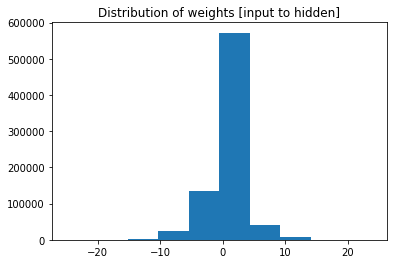

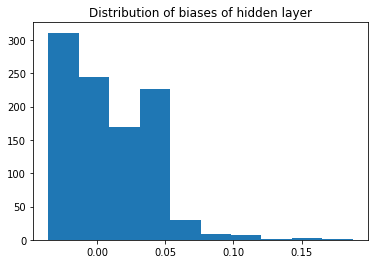

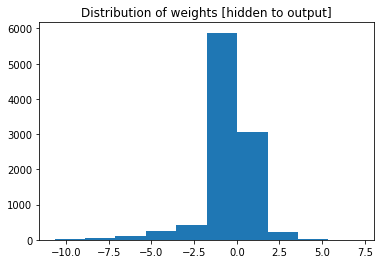

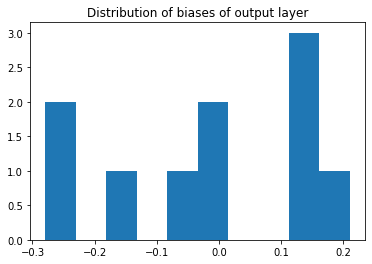

In [16]:
plot_weight_dist(model_ffnn)

## Batch Normalization

**Batch normalization** simply normalizes the *inputs to each layer* within the network according to the current batch while training. Below we build two models with and without the BN layers.

In [17]:
# ==============================================================================
# Build a normal Feedforward Neural Network with BN layer
# ==============================================================================
class BN_FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.__input_to_hidden_layer = nn.Linear(784,1000)
        self.__hidden_layer_activation = nn.ReLU()
        self.__batch_norm = nn.BatchNorm1d(1000)
        self.__hidden_to_output_layer = nn.Linear(1000,10)
    def forward(self, x):
        # ------------------------------------------------------------------
        # Because we want  to know  the intermediate values,  we return both
        # value of the hidden layer after activation, and the final output. 
        # ------------------------------------------------------------------
        x = self.__input_to_hidden_layer(x)
        # ------------------------------------------------------------------
        # We normalize the value before using the Relu Activation
        # ------------------------------------------------------------------
        x = self.__batch_norm(x)
        x1 = self.__hidden_layer_activation(x)
        y = self.__hidden_to_output_layer(x1)
        return y, x1

In [18]:
# ==============================================================================
# Define the model and its optimizer
# ==============================================================================
model_bn = BN_FFNN().to(device)
optimizer_bn = Adam(model_bn.parameters(), lr=1e-3)

In [19]:
# ==============================================================================
# Train
# ==============================================================================
train_losses_bn, train_accuracies_bn, val_losses_bn, val_accuracies_bn = \
    train_procedure(model_bn, optimizer_bn, train_loader, val_loader, 
                    max_epochs)

Epoch [ 1]: Train Acc: 84.99%,           	Val Acc: 84.40%
Epoch [ 2]: Train Acc: 74.27%,           	Val Acc: 73.01%
Epoch [ 3]: Train Acc: 77.00%,           	Val Acc: 76.59%
Epoch [ 4]: Train Acc: 81.23%,           	Val Acc: 80.34%
Epoch [ 5]: Train Acc: 81.39%,           	Val Acc: 80.29%
Epoch [ 6]: Train Acc: 79.51%,           	Val Acc: 78.63%
Epoch [ 7]: Train Acc: 82.56%,           	Val Acc: 81.57%
Epoch [ 8]: Train Acc: 82.35%,           	Val Acc: 81.25%
Epoch [ 9]: Train Acc: 82.41%,           	Val Acc: 81.31%
Epoch [10]: Train Acc: 82.64%,           	Val Acc: 81.03%
Epoch [11]: Train Acc: 83.70%,           	Val Acc: 82.56%
Epoch [12]: Train Acc: 84.25%,           	Val Acc: 83.10%
Epoch [13]: Train Acc: 80.69%,           	Val Acc: 79.52%
Epoch [14]: Train Acc: 84.14%,           	Val Acc: 82.66%
Epoch [15]: Train Acc: 82.30%,           	Val Acc: 81.18%
Epoch [16]: Train Acc: 84.46%,           	Val Acc: 82.95%
Epoch [17]: Train Acc: 83.00%,           	Val Acc: 81.79%
Epoch [18]: Tr

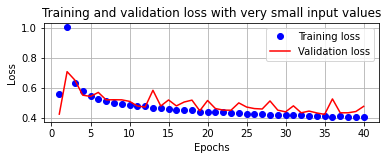

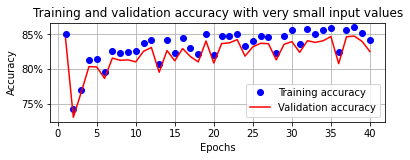

In [20]:
plot_loss_acc(train_losses_bn, val_losses_bn, train_accuracies_bn, 
              val_accuracies_bn)

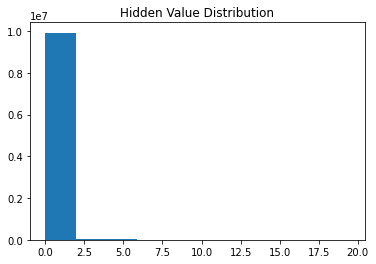

In [21]:
show_hidden_dist(model_bn, val_loader)

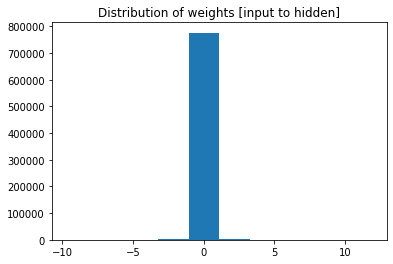

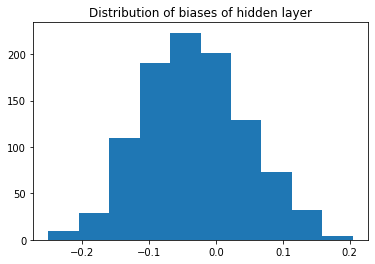

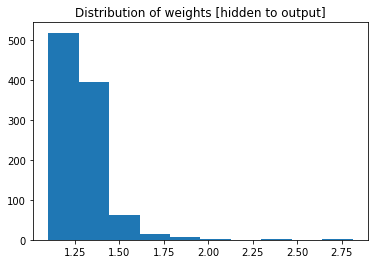

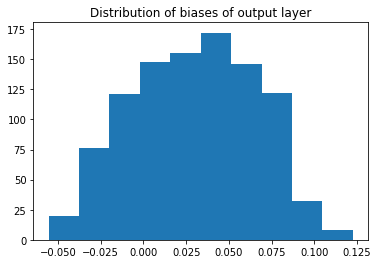

In [22]:
plot_weight_dist(model_bn)